<center><h1><b>Chapter 11.</b>The Lambert Problem</h1></center>
<center><h4> Action by <i>Juanita A. Agudelo-Quiceno, University of Antioquia</i><h4></center>
<hr>



This notebook develops the theory of chapter 4 of the book Orbital Mechanics, by Prussing. Where we will deal with theoretical and practical aspects of Lambert's problem. The objective of this notebook is to replicate the theory developed in the chapter adding interactive interfaces and complementing it with some ideas of our own that will help to a better understanding of the chapter. 

<u>To keep in mind:</u> this notebook use a python package call LambertProblem, wich is available here: <a>https://pypi.org/project/LambertProblem/0.6/</a>. In this package you will find some routines and classes that we will use during the development of the notebook, it can be downloaded by pip install LambertProblem as shown in the first cell, where the other libraries are downloaded. For a deeper understanding of the routines contained in the package you can refer to the documentation in the link presented above. 

For details on the theory please refer directly to the book:
> Prussing, J. E., & Conway, B. A. (1993). Orbital Mechanics. Oxford university press.

<h2> Section 11.1: Introduction</h2>

The Lambert problem is about solving a fundamental problem in astrodynamics, how to travel from one point to another in space?. The Lambert problem aims to find an orbit that connects the positions of two bodies in space and the flight time that separates them. There are various applications that are currently used, for example, when a spacecraft is launched into space, it is necessary to calculate the route and the time it takes to travel to its target, which can be a planet or another spacecraft moving in a known orbit. We say that the spacecraft <i>intercepts</i> the target when their positions coincide, or the spacecraft <i>rendezvous</i> with the target when they meet at the same position and velocity. Other examples may include scheduling of encounters or approaches and determination of spacecraft orbits.

In this section, we will develop the theoretical and practical concepts of the Lambert problem, its applications in real space travel, and how they help us understand the usefulness of this problem. To begin, we will illustrate a very common example in the world of space travel. It involves a spacecraft carrying supplies or even people to the International Space Station (ISS). In this case, the objective, the ISS, has an orbit that we already know, and the spacecraft, which in this case is the Russian Soyuz spacecraft, must properly dock with the space station by matching their positions and velocities to successfully take the crew of the soyuz to the space station. In summary, the Soyuz must rendezvous with the ISS.

To provide historical context to the exercise, let us imagine that the space mission is the Soyuz TMA-9. The Soyuz TMA series operated between 2002 and 2011 to transport crews to the International Space Station and serve as an emergency vehicle for it. It is a modified version of the Soyuz TM and its predecessors, with improvements in digital equipment and cabin space due to the height of the astronauts.

<style>
#hp  {
float: right;    
 margin: 0 0 0 15px;
}
img {
  border-radius: 50%;
}
</style>

<table>
    <thead>
        <tr>
            <th colspan="2" style="font-size:30px"><center>The first space tourist</center></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td colspan="2">
            <img src="media/Anousheh.jpg" alt="Anousheh Ansari, the first space tourist" width="400" height="300" id="hp"/>
            The Soyuz TMA-9 mission was a spaceflight launched on September 18, 2006, and lasted for about 10 days. The mission was a part of the International Space Station (ISS) program and was carried out by the Russian Federal Space Agency (Roscosmos).
            The Soyuz TMA-9 spacecraft carried three crew members to the ISS: Russian cosmonaut Mikhail Tyurin, American astronaut Michael Lopez-Alegria, and the first space tourist, Iranian-American entrepreneur Anousheh Ansari. Ansari paid a reported $20 million for her trip to the ISS, which made her the fourth privately funded space tourist and the first female space tourist.

During her stay on the ISS, Ansari conducted various experiments and communicated with people on the Earth through a blog. She also became the first person to deliver a video message from space to the TED Conference, which was held in Monterey, California.

The Soyuz TMA-9 mission marked a significant milestone in the history of space travel, as it demonstrated that private individuals could travel to space by paying for their trips. This paved the way for the development of commercial spaceflight and space tourism, which has gained momentum in recent years.
</td>
        </tr>
    </tbody>
</table>



So let's write some code! 

In [28]:
#prerrequisites 
!pip install -q rebound   
!pip install -q celluloid
!pip install -q plolty
!pip install -q LambertProblem


ERROR: Could not find a version that satisfies the requirement plolty (from versions: none)
ERROR: No matching distribution found for plolty


The first library is for simulations, the second one is for animations, teh third one is a very popular library for visualizations and the last one is the package for solving the Lambert Problem

Following we import the libraries required

In [12]:
#required libreries
import rebound as rb  #simulations
import matplotlib.pyplot as plt  #visualizations
import numpy as np  #math operations
from scipy import linalg  #math operations
from IPython.core.display import HTML  #display animations with HTML
import celluloid as cell  #animations
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)  #animations with matplotlib
import matplotlib.image as im  #insert images with matplotlib
import plotly.graph_objects as go  #interactive plots
from plotly.subplots import make_subplots  #interactive plots
import LambertProblem as LP  #Lambert problem package 

In the following code we start from the meeting of the ships and we perform a backward integration in time to see their orbits before the meeting. The integration is done with <b>Rebound</b>. The resulting animation is an example of a meeting in position and speed of two bodies (<i>rendezvous</i>).

<h3>Rendezvous example with the ISS and the Soyuz spacecraft</h3>

We start the simulation and add the earth with its respective value of mass and the ISS with its orbital parameters

In [2]:
sim = rb.Simulation()
sim.units = ["km","kg","s"]
sim.add(m=5.9e24)  #adding the sun mass
sim.add(m=0, a=6.7, e=6.13e-3)  #adding eccentricity and semi mayor axis orbit from ISS

We give the Soyuz a boost in speed

In [3]:
r_soyuz = np.array(sim.particles[1].xyz) + 0.001  
v_soyuz = sim.particles[1].vxyz

delta_v = 20
v_soyuz[0], v_soyuz[1] = v_soyuz[0] + delta_v, v_soyuz[1] + delta_v

sim.add(m=0, x=r_soyuz[0], y=r_soyuz[1], z=r_soyuz[2], vx=v_soyuz[0], vy=v_soyuz[1], vz=v_soyuz[2])  #adding Soyuz

We perform the integration backwards in time

In [4]:
Nt = 200
steps = np.linspace(0, 5, Nt)
r_iss = np.zeros((Nt+1, 3))
r_soyuz = np.zeros((Nt+1, 3))
r_earth = np.zeros((Nt+1, 3))

v_iss = np.zeros((Nt+1, 3))
v_soyuz = np.zeros((Nt+1, 3))

r_iss[0] = sim.particles[1].xyz
r_soyuz[0] = sim.particles[2].xyz
r_earth[0] = sim.particles[0].xyz

v_iss[0] = sim.particles[1].vxyz
v_soyuz[0] = sim.particles[2].vxyz

for i, step in enumerate(steps):
    sim.integrate(-step)

    r_earth[i+1] = sim.particles[0].xyz
    r_iss[i+1] = sim.particles[1].xyz
    r_soyuz[i+1] = sim.particles[2].xyz

    v_iss[i+1] = sim.particles[1].vxyz
    v_soyuz[i+1] = sim.particles[2].vxyz

Integration gives us the positions of the bodies in time

In [5]:
#animacion
plt.ioff()  #start animations
plt.style.use('dark_background')

fig,ax=plt.subplots(figsize=(10,8))

camera = cell.Camera(fig) 

#add images from bodies 
earth = im.imread('media/earth.png')  
Iss = im.imread('media/ISS.png')
Spyuz = im.imread('media/Soyuz.png')

#add images to animation
imagebox1 = OffsetImage(earth, zoom = 0.3)
imagebox2 = OffsetImage(Iss, zoom = 0.2)
imagebox3 = OffsetImage(Spyuz, zoom = 0.03)

#loop the positions bodies
for i in range(len(r_earth[1:10,0])):
  ab1 = AnnotationBbox(imagebox1, (r_earth[1:10,0][-i], r_earth[1:10,0][-i]), frameon = False)
  ab2 = AnnotationBbox(imagebox2, (r_iss[1:10,0][-i],r_iss[1:10,1][-i]), frameon = False)
  ab3 = AnnotationBbox(imagebox3, (r_soyuz[1:10,0][-i], r_soyuz[1:10,1][-i]), frameon = False)

  ax.plot(r_iss[:,0], r_iss[:,1], '.', markersize=1, alpha=0.5)
  ax.plot(r_soyuz[:,0], r_soyuz[:,1], '.', markersize=1, alpha=0.5)
        
  ax.plot(r_earth[1:10,0][-i],r_earth[1:10,1][-i], '.', markersize=10)
  ax.plot(r_iss[1:10,0][-i],r_iss[1:10,1][-i], '.', markersize=5)
  ax.plot(r_soyuz[1:10,0][-i],r_soyuz[1:10,1][-i], '.')

  ax.add_artist(ab1)
  ax.add_artist(ab2)
  ax.add_artist(ab3)

  camera.snap()
    
plt.close()  #close animation 
plt.ion();

In [6]:
anim = camera.animate(interval=250)  
HTML(anim.to_html5_video())

Now, we calculate the norm distance and velocity and for ISS and Soyuz to make sure that the values coincide at some point.  

In [7]:
r_iss_norm = [linalg.norm(i) for i in r_iss[1:10]]  #norm position
r_soyuz_norm = [linalg.norm(i) for i in r_soyuz[1:10]]

v_iss_norm = [linalg.norm(i) for i in v_iss[1:10]]  #velocity position
v_soyuz_norm = [linalg.norm(i) for i in v_soyuz[1:10]]

In [8]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Position vector magnitude Soyuz and ISS', 'Velocity vector magnitude Soyuz and ISS'))

#positions
fig.add_trace(go.Scatter(x=r_iss_norm, y=steps[1:10], name='r ISS', line=dict(color='firebrick', width=4)), row=1, col=1)
fig.add_trace(go.Scatter(x=r_soyuz_norm, y=steps[1:10], name = 'r Soyuz', line=dict(color='royalblue', width=4)), row=1, col=1)

#velocities
fig.add_trace(go.Scatter(x=v_iss_norm, y=steps[1:10], name='v ISS', line=dict(color='cyan', width=4)), row=1, col=2)
fig.add_trace(go.Scatter(x=v_soyuz_norm, y=steps[1:10], name = 'v Soyuz', line=dict(color='coral', width=4)), row=1, col=2)

fig.update_xaxes(title_text="Time [s]", row=1, col=1)
fig.update_xaxes(title_text="Time [km/s]", row=1, col=2)

fig.update_yaxes(title_text="Position [km]", row=1, col=1)
fig.update_yaxes(title_text="Velocity [km/s]", row=1, col=2)

fig.show()

As we can see, the position and velocity of both ships coincide at a certain point, this point is the one we call rendezvous
The rendezvous is used for docking spacecraft as in the example of the Soyuz carrying astronauts to the ISS. 

 <h2> Section 11.2: Transer Orbits Between Specified Points </h2>

<style>
.center {
  display: block;
  margin-left: auto;
  margin-right: auto;
  width: 40%;
}
</style>


To begin to deal with our problem, let us consider the geometry shown in the figure (1). Let's consider the points $P_1$ and $P_2$ located on the elipse and described by radius vectors $\vec{r_1}$ and $\vec{r_2}$ who start from the focus $F$ located at the center of atraction. The points $P_1$ and $P_2$ are separeted by the tranfer angle $\theta$ and the chord $c$. The triangle formed $P_1P_2F$ it's call the <i>space triangle</i> for the transfer. 


 <img src="media/Transfer-Orbit-Geometry.png" alt="Transfer Orbit Geometry" class="center"> 
 <center><b>Fig. 1:</b> Transfer Orbit Geometry </center>

There is a very important geometric property of ellipses that will be used to determine the transfer orbit between points $P_1$ and $P_2$. The property consists in that the sum of the distances from any point located on the ellipse and the focus and the opposite focus is a constant and has a value of $2a$ where $a$ is the value of the semi-major axis. The above property follows directly from the definition of an ellipse, <i>"the locus of all points in a plane, such that the sum of the distances to two other fixed points, called focus, is constant".</i> From de figure we have

$$
P_1 F + P_1 F^{*} = 2a 
$$

or 

$$
P_2 F + P_2 F^{*} = 2a 
$$

Thus, 

$$
P_1 F^{*} = 2a - r_1 
$$

and 

$$
P_2 F^{*} = 2a - r_2 
$$

In the following gif we show this property by creating a elipse and calculated the distance between some point and both focus. We can see that the sum $PF1$ and $PF2$ is a constant and have a value $2a$. We use the class Ellipse of the package LambertProblem to generate the positions and parameters of the ellipse.

<h3>Ellipse property animation</h3>

In [37]:
a = 3  #define any value of semi mayor axis
b = 2  #define any value of semi minor axis

elipse_property = LP.Ellipse(a=a,b=b)  #create elipse
c = elipse_property.c  

elipse_property_xy = elipse_property.get_points()

f1 = elipse_property.focus  #focus
f2 = elipse_property.vacant_focus  #vacant focus

#fuction for calculate distances
def long(x,y):
    return ((x[0]-y[0])** 2 + (x[1]-y[1])**2)**(1/2)

In [38]:
plt.ioff()  #start animation

fig,ax=plt.subplots(figsize=(8,6))
camera = cell.Camera(fig)

for i in range(len(elipse_property_xy[:,0])):
        long1 = long([elipse_property_xy[:,0][i], elipse_property_xy[:,1][i]], f1)
        long2 = long([elipse_property_xy[:,0][i], elipse_property_xy[:,1][i]], f2)

        ax.plot(elipse_property_xy[:,0], elipse_property_xy[:,1])
        ax.plot(f1[0],f1[1],'.')
        ax.plot(f2[0],f2[1], '.')
        ax.plot([f1[0], elipse_property_xy[:,0][i]], [f1[1], elipse_property_xy[:,1][i]],'bo', linestyle="--")
        ax.plot([f2[0], elipse_property_xy[:,0][i]], [f2[1], elipse_property_xy[:,1][i]],'bo', linestyle="--")

        ax.text(2.6, 2, f'PF1: {np.round(long1, 2)}', style='italic', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 2})
        ax.text(2.6, 1.80, f'PF2: {np.round(long2,2)}', style='italic', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 2})
        ax.text(2.2, 1.60, f'PF1 + PF2: {np.round(long1 + long2, 2)}', style='italic', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 2})
        ax.text(elipse_property_xy[:,0][i], elipse_property_xy[:,1][i]+0.1, r'P', fontsize=12)
        ax.text(f1[0], f1[1]-0.2, r'F1', fontsize=12)
        ax.text(f2[0], f2[1]-0.2, r'F2', fontsize=12)
        ax.set_title('Ellipse Geometric Property', fontsize=15)

        ax.set_aspect('equal', adjustable='box')

        camera.snap()
    
plt.close()
plt.ion();

In [39]:
anim = camera.animate(interval=150)
HTML(anim.to_html5_video())

The gif above ilustrate the property of the ellipses wich will be usefull for our purposes. 

<h3> Vacant focus locations </h3>

Going back to the figure 1, let us assume that $r_2 \geq r_1$, which implies no loss of generality, since the transfer orbit can be traversed in either direction. Because gravity is a conservative (nondissipative) force, one can determine the orbit that solves the boundary value problem in the reverse direction (starting at the final point $P_2$ and ending at the initial point $P_1$) by simply letting time run backward on the original orbit from $P_2$ to $P_1$. This represents a valid forward time solution with the original velocity vector replaced by its negative.

With any two points in space wich formed a space triangle, and with a specific value of a, the following interactive figure shows that if we formed a circle center in one of the points with radio $2a - r$ were $r$ is the distance between the focus and the point and if we do the same for the other point, we get that the intersection between the two circles formed is the vacant focus of the transfer ellipse. 

The interactive graph have a dropdown list were we can choose the value of $a$ and see how the circles intersec at two points, this points are the vacant focus for two possible transfer ellipse. Choosing the first value $a_m$ we see the circles meet in a single point, located on the chord that connect the two space points, in this case there are just one possible transfer elipse. This is a minimum value of $a$ for there to be an intersection, for values less than this the circles do not intersect, wich implies that there are not elliptic transfer connecting the space points and we can find this minimun value as follows

$$
(2a_m - r_2) + (2a_m - r_1) = c
$$

or

$$
a_m = s/2
$$

where 

$$
s = (r_1 + r_2 + c)/2
$$

In addition to describe the value of $a_m$ geometrically, one can also interpret it dynamically remembering that the total energy of an elliptic conic is $\epsilon = -\frac{\mu}{2a}$. It means that for the minimun value of $a$ we get the minimun energy for the ellipse transfer. Orbits having a value of $a$ less than $a_m$ simply they just don't have enough energy to travel from one point to another.

In the other hand, when the value of $a$ makes the circles intersect at two points and therefore two possible transfer orbits are generated, this two ellipse transfer will have differents eccentricities and transfer times but the same total energy. We also notice that the distance between the focus and one of the vacant focus is less than the distance between the focus and the other vacant focus, for a same value of $a$. 

We know that the distance between the focus and the vacant focus on a ellipse is $2ae$, 

$$
\overline{FF_1*} = 2ae_1 
$$

And

$$
\overline{FF_2*} = 2ae_2 
$$

The two ellipse tranfer have the same a and different e, and suppuse that the distance $\overline{FF_1*}$ is less than $\overline{FF_2*}$ so,

$$
\overline{FF_1*}  < \overline{FF_2*}  
$$

$$
2ae_1  < 2ae_2 
$$

This implies that 

$$
e_1 < e_2
$$



As we prove, one of the transfer ellipses generated for the same value of $a$ have less eccentricity

In [40]:
#two points located at any point
P1 = [1,2]
P2 = [-1,4]

F = [0,0]  #focus located at origin of coordinates 

#distance from focus to point 1
r1 = 1
#distance from focus to point 2
r2 = 1.2

c = ((P2[0]-P1[0])**2 + (P2[1]-P1[1])**2)**(1/2)
s = (r1 + r2 + c)/2

#minum value
a_m = s/2

a = [a_m, 1.5, 1.7, 2.0] #generate differents values of a for differents circle intersections

F1_list = []
F2_list = []

circulo1 = []
circulo2 = []

for i in a: 
    radio1_c = 2*i - r1
    radio2_c = 2*i - r2

    F1, F2 = LP.Ellipse.get_focus(P1, P2, radio1_c, radio2_c)  #use the get_focus static method from elipse class


    theta = np.linspace(0,2*np.pi, 100)

    #coordinates of the circle centered on P1
    circulo1_x = P1[0] + radio1_c*np.cos(theta)   
    circulo1_y = P1[1] + radio1_c*np.sin(theta)

    #coordinates of the circle centered on P2
    circulo2_x = P2[0] + radio2_c*np.cos(theta)
    circulo2_y = P2[1] + radio2_c*np.sin(theta)

    circulo1.append([circulo1_x, circulo1_y])
    circulo2.append([circulo2_x, circulo2_y])

    F1_list.append(F1)
    F2_list.append(F2)


Make the interactive plot

In [41]:
fig = go.Figure()

#para a = 1.3
fig.add_trace(go.Scatter(x=circulo1[0][0], y=circulo1[0][1], mode="lines", name=f"Circle center in P1, am = {np.round(a[0], 2)}"))
fig.add_trace(go.Scatter(x=circulo2[0][0], y=circulo2[0][1], mode="lines", name=f"Circle center in P2, am = {np.round(a[0], 2)}"))

fig.add_trace(go.Scatter(x=[F2_list[0][0]], y=[F2_list[0][1]], mode="markers+text", 
                         text=["Fm*"], textposition="bottom center", textfont=dict(size=12), 
                         marker = dict(color=["LightSeaGreen", "LightSeaGreen"]), name=f"Focus Fm*, am = {np.round(a[0], 2)}"))

#para a = 1.5
fig.add_trace(go.Scatter(x=circulo1[1][0], y=circulo1[1][1], mode="lines", name=f"Circle center in P1, a = {a[1]}", visible=False))
fig.add_trace(go.Scatter(x=circulo2[1][0], y=circulo2[1][1], mode="lines", name=f"Circle center in P2, a = {a[1]}", visible=False))

fig.add_trace(go.Scatter(x=[F1_list[1][0], F2_list[1][0]], y=[F1_list[1][1], F2_list[1][1]], mode="markers+text", 
                         text=["F1**", "F1*"], textposition="bottom center", textfont=dict(size=12), 
                         marker = dict(color=["LightSeaGreen", "LightSeaGreen"]), name=f"Focus F1*, F1** a = {a[1]}", visible=False))

#para a = 1.7
fig.add_trace(go.Scatter(x=circulo1[2][0], y=circulo1[2][1], mode="lines", name=f"Circle center in P1, a = {a[2]}", visible=False))
fig.add_trace(go.Scatter(x=circulo2[2][0], y=circulo2[2][1], mode="lines", name=f"Circle center in P2, a = {a[2]}", visible=False))

fig.add_trace(go.Scatter(x=[F1_list[2][0], F2_list[2][0]], y=[F1_list[2][1], F2_list[2][1]], mode="markers+text", 
                         text=["F2**", "F2*"], textposition="bottom center", textfont=dict(size=12), 
                         marker = dict(color=["LightSeaGreen", "LightSeaGreen"]), name=f"Focus F2*, F2** a = {a[2]}", visible=False))

fig.add_trace(go.Scatter(x=[P1[0], P2[0], F[0]], y=[P1[1], P2[1], F[1]], mode="markers+text", 
                         text=["<b>P1</b>", "<b>P2</b>", "<b>F</b>"], textposition="bottom center", textfont=dict(size=10), 
                         marker = dict(color=["turquoise", "turquoise", "turquoise"]), name="Center Points", visible=True))

fig.add_shape(type="line", xref="x", yref="y", x0=P1[0], y0=P1[1], x1=P2[0], y1=P2[1], visible=True,
              line=dict(
                        color="turquoise",
                        width=1,
                        dash="dashdot"))

fig.add_shape(type="line", xref="x", yref="y", x0=P1[0], y0=P1[1], x1=F[0], y1=F[1], visible=True,
              line=dict(
                        color="turquoise",
                        width=1,
                        dash="dashdot"))

fig.add_shape(type="line", xref="x", yref="y", x0=P2[0], y0=P2[1], x1=F[0], y1=F[1], visible=True,
              line=dict(
                        color="turquoise",
                        width=1,
                        dash="dashdot"))

fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label=f"a = {np.round(a[0], 2)}",
                     method="update",
                     args=[{"visible": [True, True, True, False, False, False, False, False, False]},
                           {"title": "Focus intersection a = 1.3"}]),
                dict(label=f"a = {a[1]}",
                     method="update",
                     args=[{"visible": [False, False, False, True, True, True, False, False, False, True, True, True]},
                           {"title": "Focus intersection a = 1.5"}]),
                dict(label=f"a = {a[2]}",
                     method="update",
                     args=[{"visible": [False, False, False, False, False, False, True, True, True, True, True, True]},
                           {"title": "Focus intersection a = 1.7"}]),           
                dict(label="All",
                     method="update",
                     args=[{"visible": [True, True, True, True, True, True, True, True, True]},
                           {"title": "Focus intersection varying the value of a"}]),
               
            ]),
        )
    ])

fig.update_layout(title=dict(text=f"Focus intersection am = {np.round(a[0], 2)}"), width=600, height=500)
fig.update_xaxes(range=[-4, 4])
fig.update_yaxes(range=[-1, 7])

fig.show()



For example, choosing a = 1.5 the circles center in $P1$ and $P2$ intersect in two points labeled $F1^*$ and $F1^{**}$. From the figure we see the distance $\overline{FF1^*}$ is less than $\overline{FF1^{**}}$, so the trasfer ellipse with focus $F$, $F1^*$ will have minor eccentricity than the other ellipse. We see this printing the distances

In [42]:
FF1_ = (F2_list[1][0]**2 + F2_list[1][1]**2)**(1/2)
FF1__ = (F1_list[1][0]**2 + F1_list[1][1]**2)**(1/2)

print(f'Distance from F to F*: {np.round(FF1_, 2)}')
print(f'Distance from F to F**: {np.round(FF1__, 2)}')

Distance from F to F*: 2.41
Distance from F to F**: 4.07


<h3>Earth-Mars Transfer</h3>

The figure above is a specific example of the two transfer orbits that are formed by the intersection of the two circles, the figure  shows the two elliptic transfer orbits for the case Earth to Mars, where $r_2 = 1.54 r_1$ with $\theta =  107°$ and specifies semimajor axis value of $a = 1.36 r_1$. 

In [9]:
r1 = 1  #distance earth - sun
r2 = 1.524*r1  #distance mars - sun 

a = 1.36*r1  #semi mayor axis for the transfer ellipse

c_r1 = 2*a - r1  #radio circle center in earth
c_r2 = 2*a - r2  #radio circle center in mars

theta = np.deg2rad(107)  #angle separation between two bodies

earth = np.array([r1,0])  #earth position

#mars position
x2 = r2*np.cos(np.pi - theta)  
y2 = r2*np.sin(np.pi - theta) 
mars = np.array([-x2,y2])

F = np.array([0,0])  #focus

Different to the previus ellipse, this ellipse is rotated so we have to use the anomaly for generate the ellipse.

In [43]:
F1_, F2_ = LP.Ellipse.get_focus(earth, mars, c_r1, c_r2)  #get the intersection

norm_F1_ = (F1_[0]**2 + F1_[1]**2)**(1/2)
phi1 = np.arccos(F1_[0]/norm_F1_)

norm_F2_ = (F2_[0]**2 + F2_[1]**2)**(1/2)
phi2 = np.arccos(F2_[0]/norm_F2_)

PF1_ = ((earth[0]-F1_[0])**2 + (earth[1] - F1_[1])**2)**(1/2)
PF1 = ((earth[0]-F[0])**2 + (earth[1] - F[1])**2)**(1/2)

PF2_ = ((earth[0]-F2_[0])**2 + (earth[1] - F2_[1])**2)**(1/2)
PF2 = ((earth[0]-F[0])**2 + (earth[1] - F[1])**2)**(1/2)

a1 = (PF1_ + PF1)/2
FF1_ = ((F1_[0] - F[0])**2 + (F1_[1] + F[1])**2)**(1/2)

a2 = (PF2_ + PF2)/2
FF2_ = ((F2_[0] - F[0])**2 + (F2_[1] + F[1])**2)**(1/2)

c1 = FF1_/2
e1 = c1/a1

c2 = FF2_/2
e2 = c2/a2

alpha = np.linspace(0,2*np.pi, 100)

r1 = a1*(1-e1**2)/(1+e1*np.cos(alpha))

x1 = r1*np.cos(alpha) 
y1 = r1*np.sin(alpha) 
beta1 = phi1-np.pi
x_elipse1 = x1*np.cos(beta1) - y1*np.sin(beta1) 
y_elipse1 = x1*np.sin(beta1) + y1*np.cos(beta1) 

r2 = a2*(1-e2**2)/(1+e2*np.cos(alpha))

x2 = r2*np.cos(alpha) 
y2 = r2*np.sin(alpha) 
beta2 = phi2-np.pi
x_elipse2 = x2*np.cos(beta2) - y2*np.sin(beta2) 
y_elipse2 = x2*np.sin(beta2) + y2*np.cos(beta2)


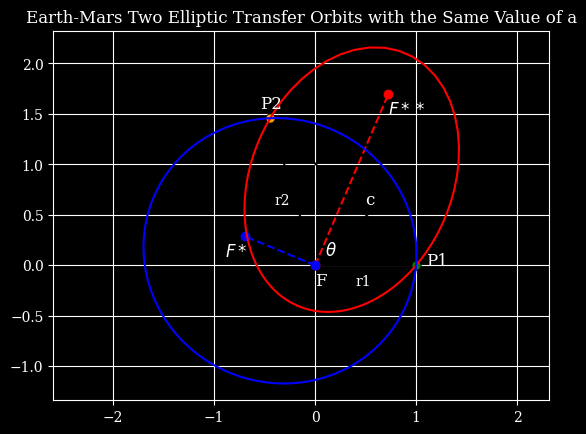

In [44]:
plt.plot([earth[0], mars[0]], [earth[1], mars[1]],'o', color='black', linestyle="-")
plt.plot([F[0], mars[0]], [F[1], mars[1]],'o', color = 'black', linestyle="-")
plt.plot([F[0], earth[0]], [F[1], earth[1]],'o', color='black', linestyle="-")
plt.plot([F[0], F1_[0]], [F[1], F1_[1]],'ro', linestyle="--")
plt.plot([F[0], F2_[0]], [F[1], F2_[1]],'bo', linestyle="--")
plt.plot(earth[0], earth[1], '.', markersize=10, color='green')
plt.plot(mars[0], mars[1], '.', markersize=10, color='orange')
plt.plot(x_elipse1, y_elipse1, color='red')
plt.plot(x_elipse2, y_elipse2, color='blue')

plt.text(F[0], F[1]-0.2, r'F', fontsize=12)
plt.text(F[0]+0.1, F[1]+0.1, r'$\theta$', fontsize=12)
plt.text(F[0]+0.4, F[1]-0.2, r'r1', fontsize=10)
plt.text(F[0]-0.4, F[1]+0.6, r'r2', fontsize=10)
plt.text(F1_[0], F1_[1]-0.2, r'$F**$', fontsize=12)
plt.text(F2_[0]-0.2, F2_[1]-0.2, r'$F*$', fontsize=12)
plt.text(earth[0]+0.1, earth[1], r'P1', fontsize=12)
plt.text(mars[0]-0.1, mars[1]+0.1, r'P2', fontsize=12)
plt.text(0.5, 0.6, r'c', fontsize=12)
plt.title('Earth-Mars Two Elliptic Transfer Orbits with the Same Value of a')
plt.grid()

plt.axis("equal");

The value of the eccentricities are 

In [45]:
print('Eccentricity ellipse FF**: ', np.round(e1, 2))
print('Eccentricity ellipse FF*: ', np.round(e2, 2))

Eccentricity ellipse FF**:  0.68
Eccentricity ellipse FF*:  0.28


Now calculate the total energy to compare then in the two ellipses. 

In [46]:
mu = 6.67e-11*1.9e30 
energy1 = -mu/(2*a1*1.496e+11)
energy2 = -mu/(2*a2*1.496e+11)

print('Total energy ellipse FF**:', np.round(energy1, 2))
print('Total energy ellipse FF*:', np.round(energy2,2))


Total energy ellipse FF**: -311443260.46
Total energy ellipse FF*: -311443260.46


The total energy for both ellipses are the same.

Other interesting property has to do with the eccentricity vector $\vec{e}$, this vector is normal to the chord c. To prove this, let's start from the definition of $\vec{e}$

$$
\vec{e} = \frac{\dot{\vec{r}} \times \vec{h}}{\mu} - \frac{\vec{r}}{r}
$$

Let's do $\vec{e} \cdot \vec{r}$

$$
\vec{e} \cdot \vec{r} = \frac{(\dot{\vec{{r}}} \times \vec{h}) \cdot \vec{r}}{\mu} - \frac{\vec{r} \cdot \vec{r}}{r}
$$

But we know $(\dot{\vec{r}} \times \vec{h})\cdot \vec{r} = \vec{h} \cdot (\vec{r} \times \dot{\vec{r}})$  

$$
\vec{e} \cdot \vec{r} = \frac{\vec{h} \cdot (\vec{r} \times \dot{\vec{r}})}{\mu} - r
$$

and $\vec{h} = \vec{r} \times \dot{\vec{r}}$

$$
\vec{e} \cdot \vec{r} = \frac{h^2}{\mu} - r
$$

Using $p = \frac{h^2}{\mu}$

$$
\vec{e} \cdot \vec{r} = p - r
$$

If we write 

$$
\vec{e} \cdot \vec{r_1} = p - r_1
$$

$$
\vec{e} \cdot \vec{r_2} = p - r_2
$$

Then 

$$
p = (\vec{e} \cdot \vec{r_1}) + r_1
$$

$$
p = (\vec{e} \cdot \vec{r_2}) + r_2
$$

We have 

$$
-\vec{e}\cdot(\vec{r_2} - \vec{r_1}) = r_2 - r_1
$$

Dividing by c

$$
-\vec{e}\cdot\frac{(\vec{r_2} - \vec{r_1})}{c} = \frac{r_2 - r_1}{c}
$$

The term $\vec{r_2} - \vec{r_1}/c$ is a unit vector formed from $P_1$ to $P_2$ so the equation implies that the eccentricity vectors for all the transfer orbits have a constant projection along the chord direction. This, in turn, implies that the locus of the eccentricity vectors is a straight line normal to the chord

 ## Section 11.3: Lambert's Theorem 

A primary concern in orbit transfer is the transfer time, defined as the time
required to travel from point $P_1$ to point $P_2$. In the spacecraft targeting
example mentioned earlier, the spacecraft is at point $P_1$ in its orbit at a time
$t_1$ and the target will be at point $P_2$ in its orbit at a later time $t_2$. The transfer
time is then $t_2 - t_1$ and the crucial issue is the determination of the transfer
orbit that connects the specified endpoints in the given transfer time.
Because of the work of Johann Heinrich Lambert (1728-1779), this is often
called Lambert's problem.
The theorem which bears his name is due to his conjecture in 1761,
based on geometric reasoning, that <i>the time required to traverse an elliptic
arc between specified endpoints depends only on the semimajor axis of the
ellipse, and on two geometric properties of the space triangle, namely the
chord length and the sum of the radii from the focus to points $P_1$ and $P_2$</i>.

<style>
#hp  {
float: right;    
 margin: 0 0 0 15px;
}
img {
  border-radius: 50%;
}
</style>

<table>
    <thead>
        <tr>
            <th colspan="2" style="font-size:30px"><center>Johann Heinrich Lambert</center></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td colspan="2">
            <img src="media/Lambert.png" alt="Anousheh Ansari, the first space tourist" width="400" height="400" id="hp"/>
            Johann Heinrich Lambert was born on August 26, 1728, in the city of Mulhouse, which was part of the Alsace region of the Holy Roman Empire (present-day France). Lambert grew up in a modest family, and his father was a tailor.

Despite limited financial resources, Lambert displayed exceptional mathematical talent from a young age. He received his primary education from his father, who recognized and nurtured his son's abilities. Lambert's aptitude for mathematics soon became evident, and he continued his studies independently. At the age of 12, Lambert began attending the Gymnasium in Mulhouse, where he studied languages, philosophy, and mathematics. He excelled in mathematics and drew the attention of his teachers and mentors. Recognizing his talent, they supported his further studies and encouraged him to pursue a career in mathematics.

Lambert's mathematical pursuits continued throughout his life. He delved into various branches of mathematics, including trigonometry, geometry, calculus, and number theory. Lambert developed his own mathematical methods and notation, making significant contributions to these fields. In addition to mathematics, Lambert also had a deep interest in physics, astronomy, and philosophy. He conducted research in optics, celestial mechanics, hydrodynamics, and mechanics. Lambert's interdisciplinary approach to science and philosophy allowed him to make significant advancements in multiple fields.

Lambert's most notable works include his treatise on hyperbolic functions, his theorem on quadrilaterals inscribed in a circle (Lambert's Theorem), and his studies on the nature of light and reflection (Lambertian reflectance). Despite his achievements, Lambert faced some challenges in gaining recognition and financial stability during his lifetime. He held various teaching positions in different cities, including Berlin and St. Petersburg. However, he faced difficulties in finding stable employment and financial support, often struggling to make ends meet.

Johann Heinrich Lambert passed away on September 25, 1777, in Berlin, Prussia (now Germany), at the age of 49. His contributions to mathematics, physics, and philosophy laid the foundation for future developments in these fields. Lambert's work continues to be studied and appreciated by mathematicians, scientists, and philosophers, as his innovative ideas and discoveries have had a lasting impact on various disciplines.
</td>
        </tr>
    </tbody>
</table>

In order to derive the Lambert Equation, we make use of the kepler equation. The essential difference here is that Lambert’s problem is an orbital boundary value problem, whereas Kepler’s equation describes an initial value problem. If one lets E 2 and E ! denote the (unknown) values of eccentric anomaly at times $t_2$ and $t_1$ on the transfer ellipse, Kepler’s equation yields:

$$
\sqrt{\mu}(t_2 - t_1) = a^{3/2}(E_2 - E_1 - e(\sin{E_2} - \sin{E_1}))
$$

According to the Lambert problem, the transfer time depends on the semi-major axis and on the positions of the bodies, so we must express the anomalies in convenient terms for our problem.

$$
E_p = 1/2(E_2 + E_1)
$$

$$
E_M = 1/2(E_2 - E_1) > 0 
$$

Usign the fact that $r = a(1 - e\cos{E})$

$$
r_1 + r_2 = a(2 - e(\cos{E_1} + \cos{E_2}))
$$

$$
r_1 + r_2 = 2a(1 - e\cos{E_p}\cos{E_M})
$$



We know that for a ellipse with center in the center of coordinates and with the major axis along the x axis we have $x = a\cos{E}$, $y = b\cos{E}$, $b = a(1- e^2)^{1/2}$. The chord distance is obtained as 

$$
c^2 = (x_2 - x_1)² + (y_2 - y_1)^2 
$$

$$
c^2 = a^2[(\cos{E_2} + \cos{E_1})^2 + (1-e^2)(\sin{E_2} - \sin{E_1})²]
$$

$$
c^2 = 4a^2 \sin^2{E_M} (1-e^2\cos^2{E_p})
$$

The temptation is irresistible to let 

$$
\cos{\xi} = e\cos{E_p}
$$

So,

$$
c = 2a \sin{E_M} \sin{E_p}
$$ 

That way we are left

$$
r_1 + r_2 = 2a(1-\cos{E_M}\cos{E_p})
$$

Let

$$
\alpha = \xi + E_m
$$

And 

$$
\beta = \xi - E_m
$$

We combine and let 

$$
r_1 + r_2 + c = 2a(1 - \cos{\alpha}) = 4a\sin^2{\alpha/2}
$$

$$
r_1 + r_2 - c = 2a(1 - \cos{\beta}) = 4a\sin^2{\beta/2}
$$

The equation for the transfer time become 
$$
\sqrt{\mu} (t_2-t_1) = 2a^{3/2}(E_M - \cos{\xi}\sin{E_M}))
$$

Finnaly, 
$$
\sqrt{\mu} (t_2-t_1) = a^{3/2}(\alpha - \beta - (\sin{\alpha} - \sin{\beta}))
$$

The followin is the Lambert Equation and and we will use it to solve Lambert's problem. As we can see, this equation fulfills the statement of the theorem, the transfer time depends only on the semi-major axis and the position of the bodies, i.e. their distance from the focus.

$$
\boxed{\sqrt{\mu} (t_2-t_1) = a^{3/2}(\alpha - \beta - (\sin{\alpha} - \sin{\beta}))}
$$

The equation describes the elliptic transfer time $t_2 - t_1$ for the case of less than one complete revolution $0 < \theta < 2\pi$,

Where

$$
\sin(\frac{\alpha}{2}) = (\frac{s}{2a})^{1/2}
$$

$$
\sin(\frac{\beta}{2}) = (\frac{s-c}{2a})^{1/2}
$$

Due to the nature of sine functions, return two main values for the angles, we can get all the values with the following

\begin{equation}
\begin{matrix}
0 \leq \theta < \pi & \beta = \beta_0, \alpha = \alpha_0\\
\pi \leq \theta < 2\pi & \beta = -\beta_0, \alpha = 2\pi - \alpha_0 
\end{matrix}
\end{equation}

<h3>Earth-Mars transfer time and semi mayor axis</h3>

Now, using the Lambert equation we can find the trasfer times for different values of semi mayor axis $a$ for the example of the transfer orbit Earth - Mars. 

In the following example, we use the same values for the transfer orbit between the earth and mars. $r_1 = 1$ au, $r_2 = 1.5r_1 $ au and $\theta = 75°$. In this case, the chord c, $c = 1.592$ au and the semiperimeter s, $s = 2.058 $ au, the value for $am$ calculated is $am = 1.03 $ au

In [10]:
#canonic units

G = 6.67e-11
UM = 1.98e30 #sun mass
UL = 1.496e11 #m distance earth sun

UT = ((UL**3)/(G*UM))**(1/2) #canonic unit of time

day_seg = 60*60*24  #seconds of a day

r1 = 1 
r2 = 1.524*r1
theta = np.deg2rad(75)

c = np.sqrt(r1**2 + r2**2 - 2*r1*r2*np.cos(theta))
s = (r1 + r2 + c)/2
am = s/2  #am minimum value

In [11]:
a = np.linspace(am, 1.5, 100)  #generate different values of a

t1 = np.zeros_like(a)
t2 = np.zeros_like(a)

for i in range(len(a)):
    time1,time2 = LP.LambertProblem(r1, r2, theta, a=a[i])  #using LambertProblem method for the package
    t1[i] = time1
    t2[i] = time2

t1 = (t1*UT)/day_seg
t2 = (t2*UT)/day_seg

tm1, tm2 = LP.LambertProblem(r1, r2, theta, a=am)
tm1 = (tm1*UT)/day_seg
tm2 = (tm2*UT)/day_seg

We can also calculate the time of minumun energy $tm$ required which corresponds to the value of $am$ minimum (in which the circles intersect at a single point).

In [48]:
print('minimun time (am) in days: ', tm1)

minimun time (am) in days:  181.66218150365336


This means that the minimum time it would take for a spacecraft to travel from earth to mars for a value of $am$ is 186 days.

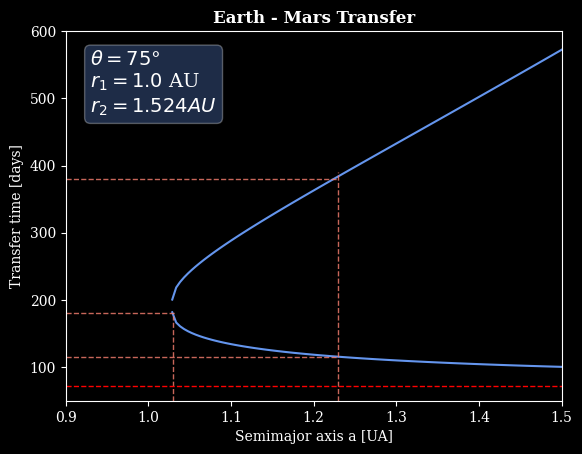

In [49]:
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.facecolor'] = 'white'

ax.plot(a, t1, color='#6495ED')
ax.plot(a, t2, color='#6495ED')

textstr = '\n'.join((
    r'$\theta=%.f$°' % (75, ),
    r'$r_1=%.1f$ AU' % (r1, ),
    r'$r_2=%.3f AU$' % (r2, )))

props = dict(boxstyle='round', facecolor='#6495ED', alpha=0.3)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel('Semimajor axis a [UA]')
ax.set_ylabel('Transfer time [days]')
ax.set_xlim(0.9, 1.5)
ax.set_ylim(50, 600)
plt.axvline(1.23, ymin=0, ymax=0.62, color = "#FA8072", linewidth = 1, linestyle = "dashed", alpha=0.8)
plt.axvline(1.03, ymin=0, ymax=0.23, color = "#FA8072", linewidth = 1, linestyle = "dashed", alpha=0.8)
plt.axhline(115, xmin=0, xmax=0.55, color = "#FA8072", linewidth = 1, linestyle = "dashed", alpha=0.8)
plt.axhline(181, xmin=0, xmax=0.22, color = "#FA8072", linewidth = 1, linestyle = "dashed", alpha=0.8)
plt.axhline(380, xmin=0, xmax=0.55, color = "#FA8072", linewidth = 1, linestyle = "dashed", alpha=0.8)
plt.axhline(72, color = "red", linewidth = 1, linestyle = "dashed")
plt.title('Earth - Mars Transfer', weight="bold");

We know how to solve the Lambert problem given certain values for the semi-major axis, we can obtain the transfer times for each value of a. But what if we want to know the transfer orbit given a certain time of flight $t$? We can solve the lambert problem now numerically, using newton raphson integration to solve the lambert equation given a value of $t$, this should give us the value of the semi-major axis of the transfer orbit. The integration is performed in the LamberProblem package.

For a transfer time $t_2 - t_1$ equal to 115 days = 1.978 time units, Lambert ecuation can be solved by numerical iteration for the value of $a$ as follows

In [50]:
r1 = 1 
r2 = 1.524*r1
theta = np.deg2rad(75)
t = 1.978

a = LP.LambertProblem(r1 = r1, r2 = r2, theta = theta, t = t)

In [51]:
print('Value of semi mayor axis for a transfer time equal to 115 days: ', np.round(a,3))

Value of semi mayor axis for a transfer time equal to 115 days:  1.232
